# ROLL NUMBER: EE21B062
# NAME: JUSTIN JEREMIAH RANGAD

# APL ASSIGNMENT WEEK4:
In this week's Applied Programming Lab Assignment we will learn and implement a digital circuit solver.

## Things we need to implement:
### 1. A Digital Netlist parser
### 2. Using networkx to create a DAG and sort it in topological order
### 3. Solve the netlist using the topological evaluation approach and timeit
### 4. Solve the netlist using the event driven approach and timeit
### 5. Provide a comparison between the two approaches and why one is better than the other


## 1. Circuit Parser:
To implement a netlist parser, I read the file and broke it down to words using the split method. From ther I created a list of edges and added the attributes to each of the nodes.

In [1]:
# circuit parser:
def parser_netlist(filename):
    with open (filename,'r') as f:
        ckt=f.read()
    net=ckt.splitlines()
    #first we have to create a list of edges of the DAG:
    edges=[]
    attributes={}
    nodes=set()
    for i in net:
        gate=i.split()
        if len(gate)==5:
            for k in range(2,4):
                edges.append((gate[k],gate[4]))
                nodes.add(gate[k])
            nodes.add(gate[4])
            attributes[gate[4]]=gate[1]
        else:
            edges.append((gate[2],gate[3]))
            nodes.add(gate[2])
            nodes.add(gate[3])
            attributes[gate[3]]=gate[1] #To get the attributes of each node
        for i in nodes:
            if i not in attributes:
                attributes[i]="PI" #Specificity for Primary inputs
    return [edges,attributes,nodes]


In [2]:
ckt=input("Please enter the circuit you want to evaluate (file must be in the form xx.net):")
out=parser_netlist(ckt)      
inp=input("Please enter the inputs to the circuit (file must be in the form xx.inputs)")

Please enter the circuit you want to evaluate (file must be in the form xx.net): c17.net
Please enter the inputs to the circuit (file must be in the form xx.inputs) c17.inputs


## 2. Creating the DAG
The DAG (Directed Acyclic Graph) can be created by using the .Digraph() method of the networkx library. We can also display the DAG using pyplot to easily see if there are any loops in the circuit. This will cause and error as the program only evaluates circuits without feedback. 

[('n_3', {'gateType': 'nand2'}), ('N22', {'gateType': 'nand2'}), ('n_0', {'gateType': 'nand2'}), ('N23', {'gateType': 'nand2'}), ('n_2', {'gateType': 'nand2'}), ('n_1', {'gateType': 'nand2'}), ('N2', {'gateType': 'PI'}), ('N7', {'gateType': 'PI'}), ('N1', {'gateType': 'PI'}), ('N3', {'gateType': 'PI'}), ('N6', {'gateType': 'PI'})]
The plot of the DAG:


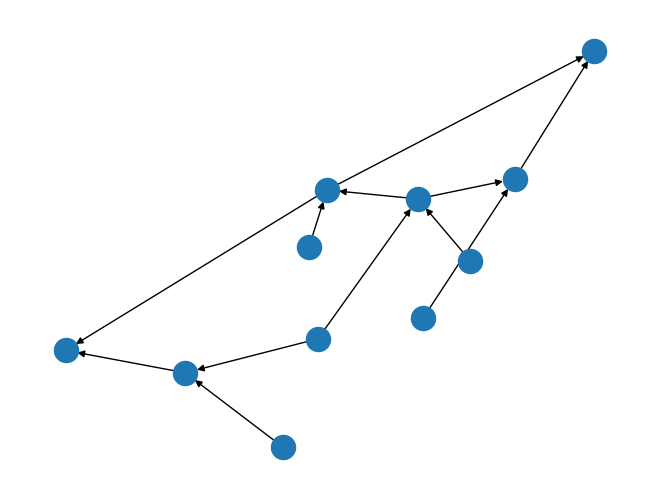

In [3]:
#Now we make the DAG and sort it according to topological order:
import networkx as nx
import matplotlib.pyplot as plt

#Create a DAG
out=parser_netlist(ckt)
g=nx.DiGraph()

#add nodes and edges to the DAG:
g.add_edges_from(out[0])
nx.set_node_attributes(g,out[1],name="gateType")

#plotting the graph
if len(g.nodes)<20:
    nx.draw(g)
    plt.savefig("filename.png")

#printing the data of each node 
print(g.nodes(data=True))
print("The plot of the DAG:")

In [4]:
#Now we perform a topological sort :
cycles=list(nx.simple_cycles(g))
if (len(cycles)>0):
    print("A CYCLE EXISTS THE CIRCUIT IS NOT A DAG. IT CANNOT BE EVALUATED BY THIS CODE")#Checks if the graph is a DAG
n1=list(nx.topological_sort(g))
print('Nodes in topolgical order',n1)

Nodes in topolgical order ['N2', 'N7', 'N1', 'N3', 'N6', 'n_0', 'n_1', 'n_3', 'n_2', 'N22', 'N23']


### 3. Input parser and Gate evaluation:
Before we solve the circuit we must first parse the inputs to the circuit. We must also write a function that mimics the functionality of each of the required logic gates. This is easily done as python has bitwise operators.

In [5]:
#A parser function for the inputs
import numpy as np
def inputs_parser(filename):
    with open(filename,'r') as f:
        lines = [line.split() for line in f]
    return(np.array(lines))

In [6]:
def func_eval(pred,opp):   #Uses bitwise operators to mimic functionality of gates
                    #evaluation and gates:
                    if opp.lower()=="and2":
                        output=int(pred[0]&pred[1])
                    #evaluation of or gates:
                    if opp.lower()=="or2":
                        output=int(pred[0]|pred[1])
                    #evaluationn of nand gates:
                    if opp.lower()=="nand2":
                        output=int(~(pred[0] & pred[1]))+2
                     #evaluation of not gate:
                    if opp.lower()=="not":
                        output=int(~pred[0])+2
                    #evaluation of nor gate:
                    if opp.lower()=="nor2":
                        output=int(~(pred[0]|pred[1]))+2
                    #evaluation of Xor gate:
                    if opp.lower()=="xor2":
                        output=int(pred[0]^pred[1])
                    #evaluation of XNOR:
                    if opp.lower()=="xnor2":
                        output=int(~(pred[0]^pred[1]))+2
                    if opp.lower()=="inv":
                        output=int(~pred[0])+2
                    return output
                    
    

## Now we want to evaluate the combinational circuit
### This can be done 2 ways:
### a. Topologically 
### b. Event Driven 

## 4a. Topological evaluation:
In this approach we take the topologically sorted DAG and evaluate it one node after the other this way all the nodes will be evaluated before their successors and hence we can create a dictionary containing the nodes and their corresponding values. For a new set of inputs we have to re-evaluate start from the bottom of the topo sorted list list again.

In [7]:
def topo_eval(g,PI,inputs,NI,l):
    output=l
    for i in range(len(PI)):
        output[PI[i]]=inputs[i]
    for j in range(len(PI),len(NI)):
        opp=g.nodes[NI[j]]["gateType"]
        pred=list(g.predecessors(NI[j]))
        val=[]
        for i in pred:
            val.append(int(output[i]))
        output[NI[j]]=func_eval(val,opp) #Calls func_eval to evaluate the operation
    return(output)

## An output printer and Timing:
To display the output correctly I created an output printer which drives the topo_eval function and also prints the 
Outputs in the correct format. Also I timed the topological solver using timeit.

In [8]:
def output_(filename,g,func,NI):
    arr=inputs_parser(filename)
    PI=arr[0]
    n1=sorted(NI)
    l={}
    for i in range(1,len(arr)):
        k=func(g,PI,arr[i],NI,l)
        l=k
def output_printer(filename,g,func,NI):
    arr=inputs_parser(filename)
    PI=arr[0]
    n1=sorted(NI)
    print(f"List of all nets in the circuit:",end="    ")
    for i in n1:
        print(i,end=" "*(len(i)-1))
    print()
    l={}
    for i in range(1,len(arr)):
        k=func(g,PI,arr[i],NI,l)
        l=k
        if i>9:
                print(f"List of states for input vector {i}:",end=" ")
        else:
                print(f"List of states for input vector {i}:",end="  ")
        for i in sorted(n1):
            if len(i)>2:
                    print(l[i],end=" "*(len(i)+1))
            else:
                    print(l[i],end=" "*(len(i)))
        print()

%timeit output_(inp,g,topo_eval,n1)

168 µs ± 6.12 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
output_printer(inp,g,topo_eval,n1)

List of all nets in the circuit:    N1 N2 N22  N23  N3 N6 N7 n_0  n_1  n_2  n_3  
List of states for input vector 1:  0  1  1    1    0  0  0  1    1    1    0    
List of states for input vector 2:  0  0  0    0    1  0  0  1    1    1    1    
List of states for input vector 3:  1  0  0    0    0  0  0  1    1    1    1    
List of states for input vector 4:  0  0  0    0    1  1  1  1    0    1    1    
List of states for input vector 5:  1  1  1    0    1  1  1  0    0    1    1    
List of states for input vector 6:  1  1  1    1    1  0  0  0    1    1    0    
List of states for input vector 7:  1  1  1    0    1  1  0  0    0    1    1    
List of states for input vector 8:  1  1  1    1    0  0  0  1    1    1    0    
List of states for input vector 9:  0  1  1    1    1  0  1  1    1    0    0    
List of states for input vector 10: 0  0  0    0    1  1  0  1    0    1    1    


## Event driven approach:
In the event driven approach we make use of a queue which works on the FIFO (First in First Out) principle. Using this data structure we can keep tract which gates need to be evaluated and which gates do not. In this approach we do not need to do any unecessary work. I used deque for this task. It is an efficient queue data structure which gives O(1) for both popping from 0 and appending from the end.


In [9]:
from collections import deque
def event_driven(g,PI,inputs,l):
    queue=deque()
    output=l
    for i in range(len(PI)):
        if PI[i] in output:
            if output[PI[i]]==int(inputs[i]):
                continue
            else:
                output[PI[i]]=int(inputs[i])
                successor=list(g.successors(PI[i]))
                for l in range(len(successor)):
                    queue.append(successor[l])
                
        else:
            output[PI[i]]=int(inputs[i])
            successor=list(g.successors(PI[i]))
            for l in range(len(successor)):
                queue.append(successor[l])
    while len(queue)!=0:# when the queue is empty the circuit has been evaluated
            pred=list(g.predecessors(queue[0]))
            successor=list(g.successors(queue[0]))
            opp=g.nodes[queue[0]]["gateType"]
            if len(pred)>1:
                if (pred[0] not in output) or (pred[1] not in output):
                        queue.popleft()
                else:
                    val=[]
                    for i in pred:
                        val.append(int(output[i]))
                    output[queue[0]]=func_eval(val,opp)
                    for i in range(len(successor)):
                        queue.append(successor[i]) #adding the successors of the first element into the queue
                    queue.popleft()
            else:
                if (pred[0] not in output):
                    queue.popleft()
                else:
                    val=[]
                    for i in pred:
                        val.append(int(output[i]))
                    output[queue[0]]=func_eval(val,opp)
                    for i in range(len(successor)):
                        queue.append(successor[i])
                    queue.popleft()
                    
    return(output)

## Printing and timing the output:
Using similar output functions as those for the topological approach. I have timed the function which will help us better understand the difference between the two.

In [10]:
def output_(filename,g,func,NI):
    arr=inputs_parser(filename)
    PI=arr[0]
    n1=sorted(NI)
    l={}
    for i in range(1,len(arr)):
        k=func(g,PI,arr[i],l)
        l=k
def output_printer(filename,g,func,NI):
    arr=inputs_parser(filename)
    PI=arr[0]
    n1=sorted(NI)
    print(f"List of all nets in the circuit:",end="    ")
    for i in n1:
        print(i,end=" "*(len(i)-1))
    print()
    l={}
    for i in range(2,len(arr)):
        k=func(g,PI,arr[i],l)
        l=k
        if i>9:
            print(f"List of states for input vector {i}:",end=" ")
        else:
            print(f"List of states for input vector {i}:",end="  ")
        for i in n1:
            if len(i)>2:
                print(l[i],end=" "*(len(i)+1))
            else:
                print(l[i],end=" "*(len(i)))
        print()
output_printer(inp,g,event_driven,n1)
    

List of all nets in the circuit:    N1 N2 N22  N23  N3 N6 N7 n_0  n_1  n_2  n_3  
List of states for input vector 2:  0  0  0    0    1  0  0  1    1    1    1    
List of states for input vector 3:  1  0  0    0    0  0  0  1    1    1    1    
List of states for input vector 4:  0  0  0    0    1  1  1  1    0    1    1    
List of states for input vector 5:  1  1  1    0    1  1  1  0    0    1    1    
List of states for input vector 6:  1  1  1    1    1  0  0  0    1    1    0    
List of states for input vector 7:  1  1  1    0    1  1  0  0    0    1    1    
List of states for input vector 8:  1  1  1    1    0  0  0  1    1    1    0    
List of states for input vector 9:  0  1  1    1    1  0  1  1    1    0    0    
List of states for input vector 10: 0  0  0    0    1  1  0  1    0    1    1    


In [13]:
%timeit output_(inp,g,event_driven,n1)

441 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# A Comparison:
In digital system simulation, both topological and event-driven simulations have their own strengths and weaknesses. Topological simulations are good for analyzing the static behavior of digital circuits and are computationally expensive, while event-driven simulations are good for analyzing the dynamic behavior of circuits and are computationally efficient. The choice between topological and event-driven simulations depends on the specific needs and goals of the simulation, and some simulations may require a combination of both approaches. 
Topological simulations model the behavior of digital circuits by looking at how individual logic gates and switches behave. This is good for analyzing the static behavior of circuits, like how quickly signals propagate and how much power is used. However, it can be slow and not great at analyzing the dynamic behavior of circuits, like how signals change over time.

Event-driven simulations model digital circuits by looking at how individual events or transitions, like clock edges or input changes, affect the circuit. This is good for analyzing the dynamic behavior of circuits, like how signals change over time and how to avoid problems like glitches or errors. It can be faster than topological simulations, but may require more complex models and algorithms.

Ultimately, the choice of which simulation to use depends on what you're trying to analyze and what kind of circuit you're working with. Some simulations may even require a combination of both approaches to get a complete picture of how the circuit behaves.

For our cases the topological simulation is better as the circuits are relatively simpler.